## Testing Clustering Methods


### Load the requirements

In [3]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math

#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

In [2]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

### Slice the dataframe by one year

In [3]:
# each day is 86400/900 = 96 rows long
# each year is 86400/900 * 365 = 35040 rows long

In [ ]:
# these are the starting and ending indices for each point from when it's released to one year later
idx_arr = np.empty((2,5460),dtype=int)
x = ds.variables["Xgrid"].values
for i in range(idx_arr.shape[1]):
    # get the indices in that row in the xgrid
    thisrow = x[:,i]
    nonna = thisrow[~np.isnan(thisrow)]
    startidx = len(thisrow)-len(nonna)
    endidx = int(startidx + ((86400/900)*365))
    idx_arr[0][i] = startidx
    idx_arr[1][i] = endidx
idx_arr.shape

In [ ]:
# select the initial columns of values (at all times)
all_xgrid = ds.variables['Xgrid'].values
all_ygrid = ds.variables['Ygrid'].values
all_salt = ds.variables['salt'].values
all_temp = ds.variables['temp'].values
all_depth = ds.variables['depth'].values
all_dens = ds.variables['rho'].values

In [ ]:
# create the new grids of only single year values
xgrid = np.empty((35040,5460))
ygrid = np.empty((35040,5460))
salt = np.empty((35040,5460))
temp = np.empty((35040,5460))
depth = np.empty((35040,5460))
dens = np.empty((35040,5460))

# select in the ds.xgrid and ds.ygrid based on the values in the idx_arr
for i in range(idx_arr.shape[1]):
    idxs = idx_arr[:,i]
    thisx = all_xgrid[:,i][idxs[0]:idxs[1]]
    thisy = all_ygrid[:,i][idxs[0]:idxs[1]]
    thissalt = all_salt[:,i][idxs[0]:idxs[1]]
    thistemp = all_temp[:,i][idxs[0]:idxs[1]]
    thisdept = all_depth[:,i][idxs[0]:idxs[1]]
    thisdens = all_dens[:,i][idxs[0]:idxs[1]]
    
    # add these values to our new xgrid and ygrid for one year
    xgrid[:,i] = thisx
    ygrid[:,i] = thisy
    salt[:,i] = thissalt
    temp[:,i] = thistemp
    depth[:,i] = thisdept
    dens[:,i] = thisdens

### Add functions for dictating water mass

In [7]:
'''
What are the parameters for each water mass

AABW: >28.27 neutral density, 1066.8+ ft depth, salinity 34.6-34.75,temperature <0
MCDW: T > Tf + 0.1, neutral density 28-28.27
ISW: T < Tf - 0.05
DSW: S > 34.5, Tf-0.5 to Tf+0.1, neutral density > 28.27
AASW: salinity < 34.5 and temperature greater than Tf

What are the arrays of ending values we have
temp
Freez_temp
salt
enddens_allvals
depth

'''
'''
DEFINITIONS REQUIRED FOR CATEGORIZE2

AABW: Talley textbook
DSW, LSSW, MCDW, AASW, ISW: Portela papers
HSSW: Yoon, Talley textbook

depth of HSSW, LSSW, and MCDW are added to make sure these are read accurately

densities for these are taking from the neutral density plot in statistics/for_meeting_824_AABW_TS
'''

'\nDEFINITIONS REQUIRED FOR CATEGORIZE2\n\nAABW: Talley textbook\nDSW, LSSW, MCDW, AASW, ISW: Portela papers\nHSSW: Yoon, Talley textbook\n\ndepth of HSSW, LSSW, and MCDW are added to make sure these are read accurately\n\ndensities for these are taking from the neutral density plot in statistics/for_meeting_824_AABW_TS\n'

In [8]:
# write a function to transfer neutral density to potential density based on the files
def find_nearest(array, value):
    if value == 0:
        idx = 0
    else:
        floor = math.floor(value)
        # see if we choose the 0.5 value or the 0 value
        if value>(floor+0.5):
            # choose 0.5 value
            searchval = floor+0.5
        else:
            searchval = floor
        idx = np.abs(array - searchval).argmin()
    return idx

def pot_to_neut(salt,temp):
    '''
    inputs: temp, salt arrays
    outputs: pot_rho: an array of the potential density values
    '''
    # write the arrays of values and their equivalents
    pot_grp = np.array([25  ,25.5,26  ,26.5,27  ,27.5,28])
    neut_grp = np.array([24.95,25.5,26.1,26.7,27.3,28  ,29])
    
    # create the potential density array in the same way as TS plots are created
    pot_dens = np.array([])
    for s,t in zip(salt,temp):
        dens=gsw.rho(s,t,0) -1000
        #if dens>28:
        #    print(s,t)
        pot_dens = np.append(pot_dens,dens)
        
    # transfer this to the neutral density array based on the image in the file
    neut_dens = np.array([])
    for rho in pot_dens:
        # find the idx of the nearest lower in the neut_grp
        if not np.isnan(rho):
            idx = find_nearest(pot_grp,rho)

            # get the difference between rho and neut_grp[idx], what percent is this of idx and idx+1
            diff = rho - pot_grp[idx]
            perc = diff/(pot_grp[idx+1]-pot_grp[idx])

            # get the equivalent value in the other list and calculate neutral density
            add = perc*(neut_grp[idx+1]-neut_grp[idx])
            newval = neut_grp[idx]+add
        else:
            newval = np.nan
        neut_dens = np.append(neut_dens,newval)
        
    return neut_dens
# enddens_allvals = pot_to_neut(salt[0],temp[0])

In [30]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 HSSW, 7 is LSSW, 8 is mSW
def wmt_categorize2(temp,Freez_temp,salt,enddens_allvals,depth,dens):
    mass = np.array([],dtype=int)
    highd = 0
    lowd = 0
    for t,tf,s,rho,d,pd in zip(temp,Freez_temp,salt,enddens_allvals,depth,dens):
        # aabw
        if d <= -1066.8 and rho >= 28.27 and s>=34.6 and s<=34.75 and t<=0:
            mass = np.append(mass,0)
            
        # shelf waters
        #mSW
        elif rho >= 28.27 and s >=34.5 and t>(tf+0.1) and t<-1.7 and (d>-1000):
            mass = np.append(mass,8)
            
        # dsw
        elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=28.27:
            mass = np.append(mass,3)
        # hssw is before we reach conditions for dsw
        elif pd>=28 and (s>34.5) and (d>-1000) and t<-1.7 and t>-2: # from Yoon, Portela and 
            # add it to the list of indices of interest
            mass = np.append(mass,6)
        # lssw is from conditions too low salinity for dsw
        elif pd >= 28 and s<=34.5 and (d>-1000) and t<-1.7 and t>-2:
            mass = np.append(mass,7)
        
        # other water masses defined from portela
        # mcdw
        elif t>(tf+0.1) and rho>=28 and rho<=28.27:                             # modified tf
            mass = np.append(mass,1)
        # aasw
        elif s<=34.5 and t>=tf and rho<28:                                          # modified s
            mass = np.append(mass,4)
        # isw (also defined in yoon)
        elif t<(tf) and d<-100:                                                    # modified tf
            mass = np.append(mass,2)
        
        # other
        else:
            #if rho>28 and t>tf:
            mass = np.append(mass,5)
                
            #print(t,tf,s,rho,d,pd)
            #else:
            #    do = 1
                #print(t,tf,s,rho,d)
    return(mass)

# find these for the first and last rows of an array
mass = wmt_categorize2(temp[0],gsw.CT_freezing(salt[0],0,0),salt[0],pot_to_neut(salt[0],temp[0]),depth[0],dens[0])
mass2 = wmt_categorize2(temp[-1],gsw.CT_freezing(salt[-1],0,0),salt[-1],pot_to_neut(salt[-1],temp[-1]),depth[-1],dens[-1])

In [67]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 HSSW, 7 is LSSW, 8 is mSW

unique, indices, counts = np.unique(mass, return_index = True, return_counts=True)
print(unique)
print(counts)

[1 3 4 5 8]
[1007 1174 1673 1335  271]


### Write the water masses in time of the groups (only do once after setting functions)

In [8]:
import time

In [102]:
# # # code an entire array of values of the water mass type the same shape as ds.variables['x'].shape (65717,5460)
#wm_arr = np.empty((35040,5460))
start_time = time.time()

with open("/scratch/project_2000789/muramarg/KMeans/wm_file_year4.txt","w") as f:
#     #for i in range(5):
    for i in range(wm_arr[:,0].shape[0]): 
        if i%5000 == 0:
            print(i,"/",35040,"in",(time.time()-start_time)/60)
        # get the array values
        thisdens = dens[i]
        thistemp = temp[i]
        thissalt = salt[i]
        thisdepth = depth[i]
        thisdens = dens[i]

        # get the neutral density values
        end_dens = pot_to_neut(thissalt,thistemp)

        # characterize each value in the array
        Freez_temp = gsw.CT_freezing(thissalt,0,0)
        wm_mass = wmt_categorize2(thistemp,Freez_temp,thissalt,end_dens,thisdepth,thisdens)

        # reset the row in the wm_arr as this wm_mass
        # wm_arr[i] = wm_mass
        #wm_mass = np.nan_to_num(wm_mass, nan=-1) 
        f.write(" ".join(str(item) for item in wm_mass))
        f.write("\n")
    
f.close()

0 / 35040 in 3.9736429850260414e-05
5000 / 35040 in 17.055138850212096
10000 / 35040 in 33.288342674573265
15000 / 35040 in 48.668290229638416
20000 / 35040 in 64.0182810028394
25000 / 35040 in 79.36151237885157
30000 / 35040 in 94.70613290071488
35000 / 35040 in 110.05025937159856


In [9]:
# test reading the file
with open("/scratch/project_2000789/muramarg/KMeans/wm_file_year4.txt","r") as f:
# with open("wm_alter.txt","r") as f:
    a = f.readlines()
    wm_arr = np.empty((35040,5460))
    for i in range(35040):
        b = a[i].split(" ")
        b = np.asarray(b)
        b[-1] = b[-1][:-1]
        b = b.astype(float)
        wm_arr[i] = b
f.close()

In [34]:
# 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is hssw, 7 is lssw, 8 is msw

### Likelihood of any one water mass ending as another water mass

In [35]:
# release months to find seasonal variability
with open("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/release_months.txt","r") as f:
    lines = f.readlines()
f.close()

In [68]:
set(mass)

{1, 3, 4, 5, 8}

In [49]:
# look at the starting values
mcdw_i = (mass == 1).nonzero()[0]
dsw_i = (mass == 3).nonzero()[0]
aasw_i = (mass == 4).nonzero()[0]
other_i = (mass == 5).nonzero()[0]
msw_i = (mass == 8).nonzero()[0]

In [69]:
labels = np.array(["AABW","MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"])

In [70]:
unique, indices, counts = np.unique(mass2[dsw_i], return_index = True, return_counts=True)
dsw_counts = (np.asarray((labels[unique], counts)))
unique, indices, counts = np.unique(mass2[aasw_i], return_index = True, return_counts=True)
aasw_counts = (np.asarray((labels[unique], counts)))
unique, indices, counts = np.unique(mass2[other_i], return_index = True, return_counts=True)
other_counts = (np.asarray((labels[unique], counts)))
unique, indices, counts = np.unique(mass2[msw_i], return_index = True, return_counts=True)
msw_counts = (np.asarray((labels[unique], counts)))

In [77]:
dsw_counts1 = np.array([408,364,38,69,98,128,0,54,15])
aasw_counts1 = np.array([250,737,44,97,231,146,0,145,23])
other_counts1 = np.array([344,426,45,85,146,177,0,100,12])
msw_counts1 = np.array([108,93,0,4,37,23,0,5,1])

In [80]:
df2 = pd.DataFrame()
df2["DSW starting"] = dsw_counts1
df2["AASW starting"] = aasw_counts1
df2["HSSW starting"] = other_counts1
df2["LSSW starting"] = msw_counts1
df2.index = labels
df2

,DSW starting,AASW starting,HSSW starting,LSSW starting
AABW,408,250,344,108
MCDW,364,737,426,93
ISW,38,44,45,0
DSW,69,97,85,4
AASW,98,231,146,37
other,128,146,177,23
HSSW,0,0,0,0
LSSW,54,145,100,5
mSW,15,23,12,1


### Create the dataframe

In [10]:
# read the file and add the density values from aabw_neutral_densities.txt
with open("/scratch/project_2000789/muramarg/KMeans/df_allpts.txt","r") as g:
    inp = g.readlines()
g.close()

In [11]:
# read from the text file to make things faster
length_ratio1 = np.array([inp[0].split(',')[:-1]]).astype(float)
depth_means1 = np.array([inp[1].split(',')[:-1]]).astype(float)
depth_std1 = np.array([inp[2].split(',')[:-1]]).astype(float)
dt1 = np.array([inp[3].split(',')[:-1]]).astype(float)
dsalt1 = np.array([inp[4].split(',')[:-1]]).astype(float)
ddens1 = np.array([inp[5].split(',')[:-1]]).astype(float)
ddepth = np.array([inp[6].split(',')[:-1]]).astype(float)
shelf_time1 = np.array([inp[7].split(',')[:-1]]).astype(float)
max_dt = np.array([inp[8].split(',')[:-1]]).astype(float)
max_ddep = np.array([inp[9].split(',')[:-1]]).astype(float)

In [12]:
# create the dataframe
df = pd.DataFrame()

# other variables
df["net distance:total distance"] = length_ratio1[0]
df["mean depth"] = depth_means1[0]
df["std depth"] = depth_std1[0]
df["dT"] = dt1[0]
df["d salt"] = dsalt1[0]
df["d rho"] = ddens1[0]
df["d depth"] = ddepth[0]
df["time to shelf"] = shelf_time1[0]
df["max dT in one week"] = max_dt[0]
df["max ddepth in one week"] = max_ddep[0]
df.head()

,net distance:total distance,mean depth,std depth,dT,d salt,d rho,d depth,time to shelf,max dT in one week,max ddepth in one week
0,0.080325,-313.551639,194.063711,-1.425866,0.129398,2.782511,-548.851804,259.031250,0.001444,0.260899
1,0.155585,-377.400835,199.328909,-2.107597,0.122368,2.416227,-465.161357,152.906250,0.000997,0.246860
2,0.153895,-294.149942,170.465044,-3.122440,0.209873,1.150209,-170.680978,149.083333,0.001736,0.215706
3,0.293675,-319.259075,269.757452,-4.459709,0.338161,3.454548,-613.138906,257.677083,0.001407,0.288944
4,0.173095,-245.184471,113.584805,-2.252766,0.150261,1.317112,-228.727737,0.000000,0.002121,0.185718


In [13]:
# FIRST ROUND
df = df[["dT","d salt","d rho"]]

### SciPy Proximity Functions

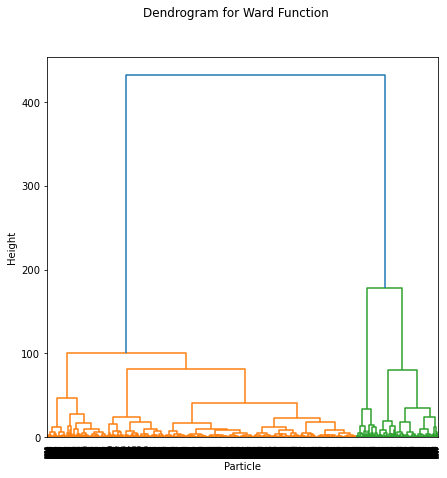

In [14]:
# Plot the dendrogram for the Ward proximity measure
index_names = list(df.index)

z = linkage(df,method='ward')
plt.figure(figsize = (7,7))
plt.suptitle('Dendrogram for Ward Function')
plt.xlabel('Particle')
plt.ylabel('Height')

dendrogramward = dendrogram(Z=z,labels=index_names,get_leaves=True)
plt.show()

In [15]:
# set the number of clusters and get the names
numclust = 6
fl = fcluster(z,numclust,criterion='maxclust')

# new dataframe
df_clst = pd.DataFrame()
df_clst['index']  = index_names
df_clst['clust_label']  = fl

# get the clusters from fcluster to choose centroids
centroids_idx = np.array([],dtype=int)
for i in range(6):
    # print the values in each group
    elements = df_clst[df_clst['clust_label']==i+1]['index'].tolist()  
    size = len(elements)    
    # get a random number from elements as a centroid
    centroids_idx = np.append(centroids_idx, random.choice(elements))
print(centroids_idx)

[1277  415 1293 3407 5331 5337]


### Find clusters based on k-means

In [16]:
# choose the centroids based on the smallest values from the particles
# we will choose the centroids at random from the 6 groups
# get the initial centroids
index_names = list(df.index)
c0 = df.iloc[index_names.index(centroids_idx[0])]
c1 = df.iloc[index_names.index(centroids_idx[1])]
c2 = df.iloc[index_names.index(centroids_idx[2])]
c3 = df.iloc[index_names.index(centroids_idx[3])]
c4 = df.iloc[index_names.index(centroids_idx[4])]
c5 = df.iloc[index_names.index(centroids_idx[5])]

centroids = np.array([c0,c1,c2,c3,c4,c5]) #c5,c6,c7,c8])

In [17]:
# Compute the k-means clusters and show the listing of the States in each cluster
kmeans = KMeans(n_clusters=6,init=centroids,n_init=1,random_state=23).fit(df)
centroids = kmeans.cluster_centers_
assignment = kmeans.fit_predict(df,centroids)

# get the cluster for each state
zeroes=[x for x,y in enumerate(assignment) if y == 0]
ones=[x for x,y in enumerate(assignment) if y == 1]
twos=[x for x,y in enumerate(assignment) if y == 2]
threes=[x for x,y in enumerate(assignment) if y == 3]
fours=[x for x,y in enumerate(assignment) if y == 4]
fives=[x for x,y in enumerate(assignment) if y == 5]

clusters = [zeroes,ones,twos,threes,fours,fives] #sevens,eights]
states = [[],[],[],[],[],[]] #[],[],[],[]]
num = 0
for clust in clusters:
    # cluster to append to is states[num]
    for idx in clust:
        state = index_names[idx]
        states[num].append(state)
    print('Cluster '+str(num)+':')
    print(len(states[num]))
    num += 1

Cluster 0:
568
Cluster 1:
950
Cluster 2:
2933
Cluster 3:
282
Cluster 4:
261
Cluster 5:
466


In [18]:
# get the indices for each of the groups
group0 = states[0]
group1 = states[1]
group2 = states[2]
group3 = states[3]
group4 = states[4]
group5 = states[5]
groups = np.array([group0,group1,group2,group3,group4,group5],dtype=object)

### Check the quality of the grouping

In [31]:
# find the number of values in each group that match each of the water masses
# we have the arrays temp, freez_temp, salt, enddens_allvals, depth
lengths = np.array([])
AABW_percents = np.array([])
MCDW_percents = np.array([])
ISW_percents = np.array([])
DSW_percents = np.array([])
AASW_percents = np.array([])
HSSW_percents = np.array([])
other = np.array([])
LSSW_percents = np.array([])
mSW_percents = np.array([])

for group in groups:
    # how many particles are in the group
    lengths = np.append(lengths,len(group))
    
    # get the individual quantities of each group from mass and do value counts
    thismass = mass2[group]
    unique_elements, counts_elements = np.unique(thismass, return_counts=True)
    
    # see if any number is not in list and if not then add 0 to the end of the list
    for i in range(9):
        if not np.any(unique_elements == i):
            # append this number and zero to unique,counts
            unique_elements = np.append(unique_elements,i)
            counts_elements = np.append(counts_elements,0)
            
    # 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is hssw, 7 is lssw
    
    for i in range(len(unique_elements)):
        if unique_elements[i] == 0:
            AABW_percents =np.append(AABW_percents,counts_elements[i])
        elif unique_elements[i] == 1:
            MCDW_percents =np.append(MCDW_percents,counts_elements[i])
        elif unique_elements[i] == 2:
            ISW_percents =np.append(ISW_percents,counts_elements[i])
        elif unique_elements[i] == 3:
            DSW_percents =np.append(DSW_percents,counts_elements[i])
        elif unique_elements[i] == 4:
            AASW_percents =np.append(AASW_percents,counts_elements[i])
        elif unique_elements[i] == 5:
            other = np.append(other,counts_elements[i])
        elif unique_elements[i] == 6:
            HSSW_percents =np.append(HSSW_percents,counts_elements[i])
        elif unique_elements[i] == 7:
            LSSW_percents = np.append(LSSW_percents,counts_elements[i])
        elif unique_elements[i] == 8:
            mSW_percents = np.append(mSW_percents,counts_elements[i])

In [32]:
wmt_df = pd.DataFrame()
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["HSSW"] = HSSW_percents
wmt_df["LSSW"] = LSSW_percents
wmt_df["mSW"] = mSW_percents
wmt_df["other"] = other
wmt_df

,# of particles,AABW,MCDW,ISW,DSW,AASW,HSSW,LSSW,mSW,other
0,568.0,279.0,12.0,33.0,19.0,0.0,0.0,1.0,1.0,223.0
1,950.0,0.0,426.0,60.0,107.0,92.0,0.0,175.0,25.0,65.0
2,2933.0,0.0,1479.0,73.0,218.0,514.0,0.0,295.0,44.0,310.0
3,282.0,282.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,261.0,261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,466.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### What are the distributions of variables in groups

In [116]:
months = np.array([],dtype=int)
for i in lines:
    months = np.append(months,float(i[:-1]))
months

array([ 1.,  1.,  1., ..., 12., 12., 12.])

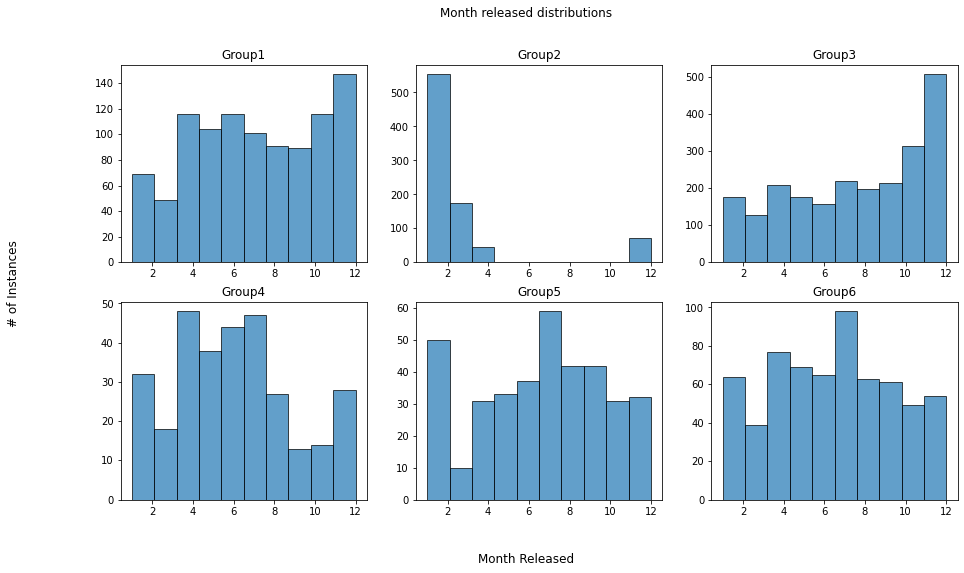

In [117]:
# # Distribution of Various Quantities
fig = plt.figure(figsize = (15,8))
plt.suptitle("Month released distributions")
fig.supxlabel('Month Released')
fig.supylabel('# of Instances')
i = 1

thisfig = df.columns[1]
for group in groups:
    ax = fig.add_subplot(2, 3, i)
    #plt.xlim(xmin=0, xmax = 2000)
    #ax.hist(df[thisfig][group].values,alpha=0.7,edgecolor="black")
    ax.hist(months[group],alpha=0.7,edgecolor="black")
    mystr = "Group" + str(i)
    #plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],labels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.xticks()
    plt.title(mystr)
    i  += 1
    
plt.savefig("/scratch/project_2000789/muramarg/KMeans/months_dist.png", dpi=300)

### Plot with depth with time, colored by density

In [21]:
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400

In [22]:
time1 = x_time0.astype(int)

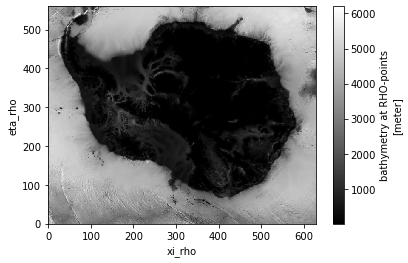

In [23]:
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))

In [24]:
# create the topography map for each value in the x and y grid
dtopo = np.empty((35040,5460))
# dtopo is the topography at each x and y point in the grids
topo = ds1.variables['h'].values

In [25]:
import scipy

In [26]:
import scipy.interpolate as scp

In [27]:
import time

In [28]:
# calculate the topography below each float

# x_shape1 = np.arange(topo.shape[1])
# y_shape1 = np.arange(topo.shape[0])

# start_time = time.time()

# with open("/scratch/project_2000789/muramarg/KMeans/topography2.txt","w") as f:
#     for i in range(len(xgrid)):
#         if i % 5000 == 0:
#             print(i,"/",len(xgrid),"in",(time.time()-start_time)/60)

#         this_row = np.array([])
#             #for j in range(len(xgrid[i])):
#             #    if (xgrid[i][j] % 1 == 0):
#             #        xi_rho = int(xgrid[i][j])
#             #        eta_rho = int(ygrid[i][j])

#                     #print(xi_rho,eta_rho,topo[eta_rho][xi_rho])
#                     #dtopo[i][j] = topo[eta_rho][xi_rho]
#             #     this_row = np.append(this_row,topo[eta_rho][xi_rho])
#             #    else:
#         xi_rho = xgrid[i] #[j]
#         eta_rho = ygrid[i] #[j]

#         ptsarr = np.array([eta_rho,xi_rho])

#         interp_arr1 = scp.interpn((y_shape1,x_shape1), topo, ptsarr.T)

#         #print(interp_arr1)

#                     #interp_mesh = np.array(np.meshgrid(xi_rho, eta_rho))
#                     #interp_points = np.rollaxis(interp_mesh, 0, 3).reshape((1, 2))
#                     #interp_arr1 = scp.interpn((x_shape1,y_shape1), topo.T, interp_points)

#                     #print(xi_rho,eta_rho,interp_arr1)
#                     #dtopo[i][j] = interp_arr1[0]
#         #this_row = np.append(this_row,interp_arr1[0])

#             #print(this_row.shape)
#         f.write(" ".join(str(item) for item in interp_arr1))
#         f.write("\n")
# f.close()

In [29]:
# test reading the file
with open("/scratch/project_2000789/muramarg/KMeans/topography2.txt","r") as f:
    a = f.readlines()
    topo_arr = np.empty((35040,5460))
    for i in range(35040):
        b = a[i].split(" ")
        b = np.asarray(b)
        b[-1] = b[-1][:-1]
        b = b.astype(float)
        topo_arr[i] = b
f.close()

In [30]:
# topo_arr

In [31]:
# depth

In [32]:
depth2 = depth*-1
d_above_topo = topo_arr - depth2
# d_above_topo

In [33]:
d_above_topo = np.where(d_above_topo<0, 0, d_above_topo)

In [40]:
sum(dens[:,group0][-1])/len(dens[:,group0][-1])

30.855565312034205

In [ ]:
# add the depth above bottom topography
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)
i = 1

fig.suptitle("Density of particles over time")
fig.supxlabel('Days since release')
fig.supylabel('Depth above topography')

for group in groups:
    print(i)
    ax = fig.add_subplot(3, 2, i)
    plt.scatter(time1[:,group],d_above_topo[:,group],marker=".",s=0.05,c=dens[:,group],vmin=26,vmax=33)
    plt.title("Group"+str(i))
    plt.colorbar(label=''r'$\sigma$')
    i += 1
plt.savefig("/scratch/project_2000789/muramarg/KMeans/rho_dabovetopo3.png", dpi=300)

1
2
3
4
5
6


1
2
3
4
5
6


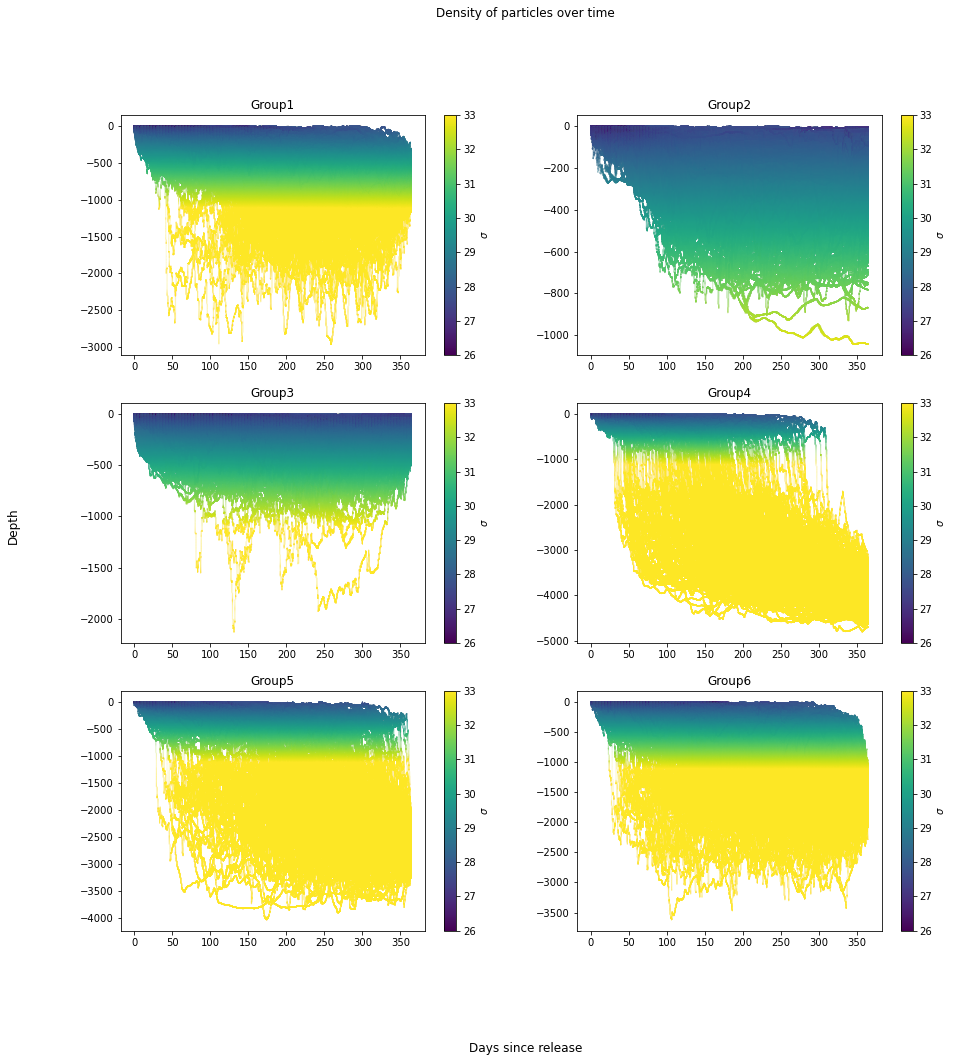

In [41]:
# plot 2 by 3 of density with depth over time of the groupings
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)
i = 1

fig.suptitle("Density of particles over time")
fig.supxlabel('Days since release')
fig.supylabel('Depth')

for group in groups:
    print(i)
    ax = fig.add_subplot(3, 2, i)
    plt.scatter(time1[:,group],depth[:,group],marker=".",s=0.01,c=dens[:,group],vmin=26,vmax=33)
    plt.title("Group"+str(i))
    plt.colorbar(label=''r'$\sigma$')
    i += 1
# plt.show()
plt.savefig("/scratch/project_2000789/muramarg/KMeans/rho_over_time3.png", dpi=300)

### Plot in Eulerian view

In [ ]:
# # test reading the file
# with open("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/wm_alter.txt","r") as f:
#     a = f.readlines()
#     wm_arr = np.empty((ds.variables['x'].shape))
#     for i in range(len(a)):
#         b = a[i].split(" ")
#         b = np.asarray(b)
#         b[-1] = b[-1][:-1]
#         b = b.astype(float)
#         wm_arr[i] = b
# f.close()

In [131]:
# flatten the groups to see what colors are in them
print(set(wm_arr[:,group0][-1].flatten()))
print(set(wm_arr[:,group1][-1].flatten()))
print(set(wm_arr[:,group2][-1].flatten()))
print(set(wm_arr[:,group3][-1].flatten()))
print(set(wm_arr[:,group4][-1].flatten()))
print(set(wm_arr[:,group5][-1].flatten()))

{1.0, 2.0, 3.0, 5.0, 7.0, 8.0}
{1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0}
{1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0}
{0.0}
{0.0}
{0.0, 2.0, 3.0, 5.0}


In [42]:
cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red","tab:purple","tab:brown","tab:cyan","tab:pink","tab:olive"])
cmap2 = ListedColormap(["tab:orange", "tab:green", "tab:red","tab:purple","tab:brown","tab:cyan","tab:pink","tab:olive"])

1
2
3
4
5
6


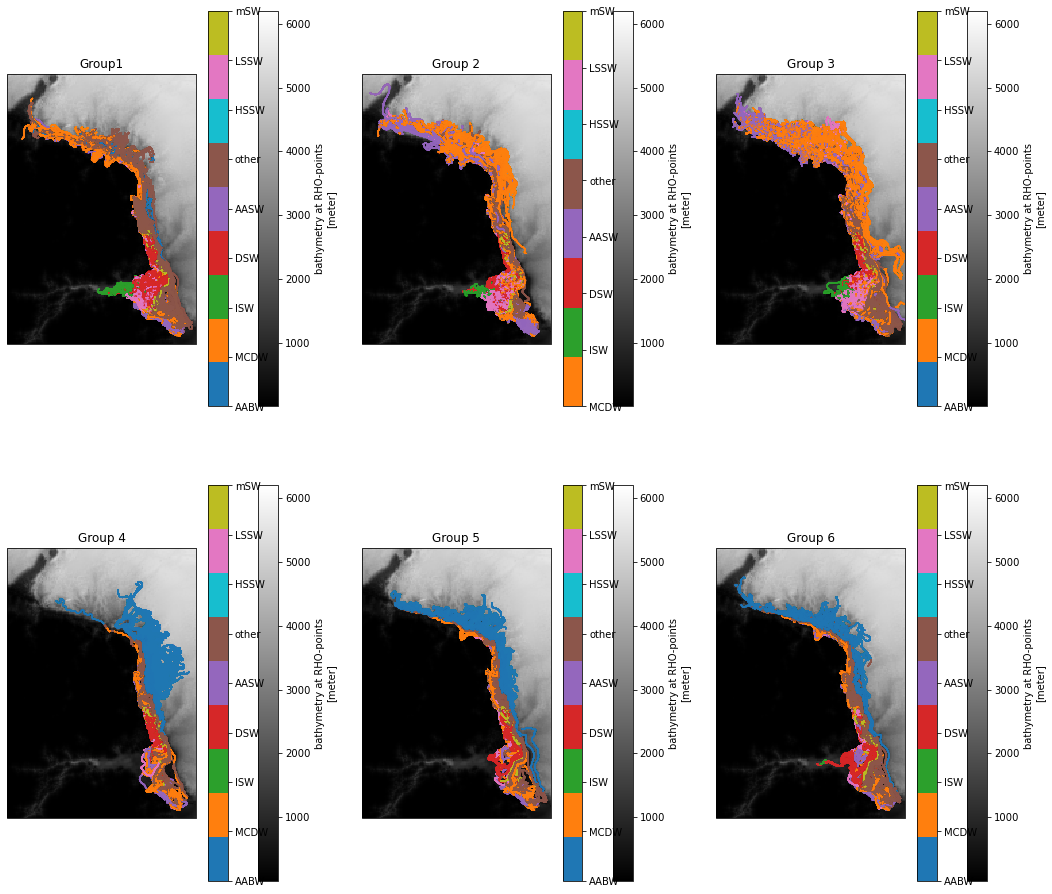

In [43]:
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(18,16))                  # this width and height gives the same ratio as 630,560 (1.125)
fig.tight_layout(pad=10)
ax = fig.add_subplot(2, 3, 1,projection=proj)
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group1")
# plot the points as different colors
plt.scatter(xgrid[:,group0],ygrid[:,group0],marker='.',s=0.1,c=wm_arr[:,group0],cmap=cmap)
labels=["AABW","MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8])
cbar.ax.set_yticklabels(labels)
print(1)

ax = fig.add_subplot(2, 3, 2,projection=proj)
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 2")
# plot the points as different colors
plt.scatter(xgrid[:,group1],ygrid[:,group1],marker='.',s=0.1,c=wm_arr[:,group1],cmap=cmap2)
labels=["MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"]
cbar = plt.colorbar(ticks=[1,2,3,4,5,6,7,8])
cbar.ax.set_yticklabels(labels)
print(2)

ax = fig.add_subplot(2, 3, 3,projection=proj)
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 3")
# plot the points as different colors
plt.scatter(xgrid[:,group2],ygrid[:,group2],marker='.',s=0.1,c=wm_arr[:,group2],cmap=cmap)
labels=["AABW","MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8])
cbar.ax.set_yticklabels(labels)
print(3)

ax = fig.add_subplot(2, 3, 4,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 4")
# plot the points as different colors
plt.scatter(xgrid[:,group3],ygrid[:,group3],marker='.',s=0.1,c=wm_arr[:,group3],cmap=cmap)
labels=["AABW","MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8])
cbar.ax.set_yticklabels(labels)
print(4)

ax = fig.add_subplot(2, 3, 5,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 5")
# plot the points as different colors
plt.scatter(xgrid[:,group4],ygrid[:,group4],marker='.',s=0.1,c=wm_arr[:,group4],cmap=cmap)
labels=["AABW","MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8])
cbar.ax.set_yticklabels(labels)
print(5)

ax = fig.add_subplot(2, 3, 6,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 6")
# plot the points as different colors
plt.scatter(xgrid[:,group5],ygrid[:,group5],marker='.',s=0.1,c=wm_arr[:,group5],cmap=cmap)
labels=["AABW","MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8])
cbar.ax.set_yticklabels(labels)
print(6)

plt.savefig("/scratch/project_2000789/muramarg/KMeans/wmt_colored_groupbyTrhos2.png", dpi=300)

In [19]:
# show the groups that form AABW in more detail

 # 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is hssw, 7 is lssw, 8 is mSW
wm_arr = np.where(wm_arr == 1, np.nan, wm_arr)
wm_arr = np.where(wm_arr == 2, np.nan, wm_arr)
wm_arr = np.where(wm_arr == 4, np.nan, wm_arr)
wm_arr = np.where(wm_arr == 5, np.nan, wm_arr)
wm_arr = np.where(wm_arr == 8, np.nan, wm_arr)

In [24]:
set(wm_arr[-1][~np.isnan(wm_arr[-1])])

{0.0, 3.0, 7.0}

In [25]:
cmap = ListedColormap(["tab:blue","tab:red","tab:cyan","tab:pink"])

In [28]:
str(len(group0))

'568'

1
2
3
4
5
6


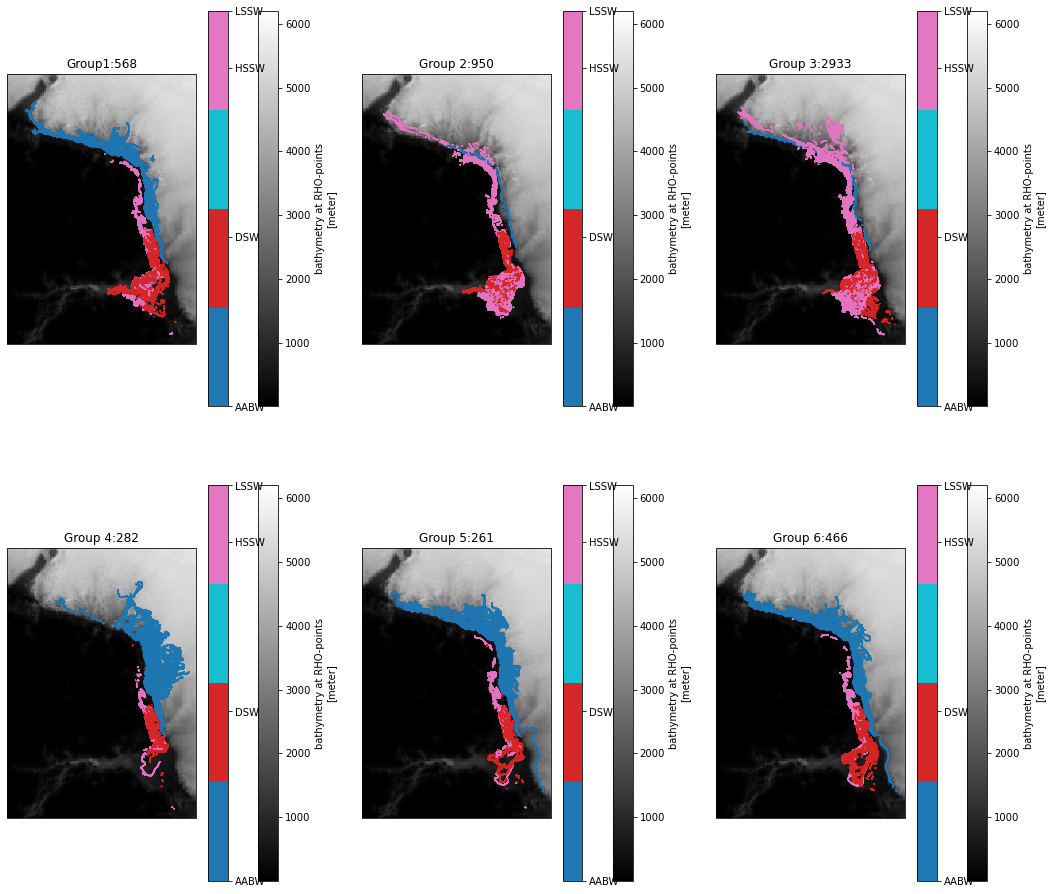

In [29]:
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(18,16))                  # this width and height gives the same ratio as 630,560 (1.125)
fig.tight_layout(pad=10)
ax = fig.add_subplot(2, 3, 1,projection=proj)
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group1:"+str(len(group0)))
# plot the points as different colors
plt.scatter(xgrid[:,group0],ygrid[:,group0],marker='.',s=0.1,c=wm_arr[:,group0],cmap=cmap)
labels=["AABW","DSW","HSSW","LSSW"]
cbar = plt.colorbar(ticks=[0,3,6,7])
cbar.ax.set_yticklabels(labels)
print(1)

ax = fig.add_subplot(2, 3, 2,projection=proj)
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 2:"+str(len(group1)))
# plot the points as different colors
plt.scatter(xgrid[:,group1],ygrid[:,group1],marker='.',s=0.1,c=wm_arr[:,group1],cmap=cmap)
labels=["AABW","DSW","HSSW","LSSW"]
cbar = plt.colorbar(ticks=[0,3,6,7])
cbar.ax.set_yticklabels(labels)
print(2)

ax = fig.add_subplot(2, 3, 3,projection=proj)
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 3:"+str(len(group2)))
# plot the points as different colors
plt.scatter(xgrid[:,group2],ygrid[:,group2],marker='.',s=0.1,c=wm_arr[:,group2],cmap=cmap)
labels=["AABW","DSW","HSSW","LSSW"]
cbar = plt.colorbar(ticks=[0,3,6,7])
cbar.ax.set_yticklabels(labels)
print(3)

ax = fig.add_subplot(2, 3, 4,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 4:"+str(len(group3)))
# plot the points as different colors
plt.scatter(xgrid[:,group3],ygrid[:,group3],marker='.',s=0.1,c=wm_arr[:,group3],cmap=cmap)
labels=["AABW","DSW","HSSW","LSSW"]
cbar = plt.colorbar(ticks=[0,3,6,7])
cbar.ax.set_yticklabels(labels)
print(4)

ax = fig.add_subplot(2, 3, 5,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 5:"+str(len(group4)))
# plot the points as different colors
plt.scatter(xgrid[:,group4],ygrid[:,group4],marker='.',s=0.1,c=wm_arr[:,group4],cmap=cmap)
labels=["AABW","DSW","HSSW","LSSW"]
cbar = plt.colorbar(ticks=[0,3,6,7])
cbar.ax.set_yticklabels(labels)
print(5)

ax = fig.add_subplot(2, 3, 6,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.h.isel().plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 6:"+str(len(group5)))
# plot the points as different colors
plt.scatter(xgrid[:,group5],ygrid[:,group5],marker='.',s=0.1,c=wm_arr[:,group5],cmap=cmap)
labels=["AABW","DSW","HSSW","LSSW"]
cbar = plt.colorbar(ticks=[0,3,6,7])
cbar.ax.set_yticklabels(labels)
print(6)

plt.savefig("/scratch/project_2000789/muramarg/KMeans/wmt_only_dsw_lssw_aabw.png", dpi=300)

### Statistics of the ending values for each of the groups

In [41]:
labels = np.array(["AABW","MCDW","ISW","DSW","AASW","other","HSSW","LSSW","mSW"])

In [53]:
set(mass)

{1, 3, 4, 5, 8}

In [61]:
# look at the starting values
mcdw_i = np.intersect1d((mass == 1).nonzero()[0],group1)
dsw_i = np.intersect1d((mass == 3).nonzero()[0],group1)
aasw_i = np.intersect1d((mass == 4).nonzero()[0],group1)
other_i = np.intersect1d((mass == 5).nonzero()[0],group1)
msw_i = np.intersect1d((mass == 8).nonzero()[0],group1)

# look at the starting values
# mcdw_i = (mass == 1).nonzero()[0]
# dsw_i = (mass == 3).nonzero()[0]
# aasw_i = (mass == 4).nonzero()[0]
# other_i = (mass == 5).nonzero()[0]
# msw_i = (mass == 8).nonzero()[0]

In [64]:
mcdw_i

array([   0,   19,   48,  204,  205,  206,  208,  209,  239,  255,  256,
        258,  259,  261,  469,  470,  487,  518,  672,  673,  802,  831,
       1089, 1091, 1300, 1315, 1316, 1317, 1348, 1349, 1350, 1351, 1406,
       1768, 1769, 1784, 1785, 1816, 1818, 1819, 1872, 1873, 1888, 1920,
       1921, 1923, 1977, 2026, 2027, 2236, 2237, 2284, 2285, 2286, 2287,
       2288, 2289, 2292, 2305, 2306, 2307, 2336, 2338, 2339, 2340, 2357,
       2358, 2387, 2388, 2391, 2393, 2758, 2808, 2809, 2810, 2856, 2858,
       2859, 3172, 3220, 3221, 3498, 3500, 3532, 3533, 3535, 3605, 3634,
       3745, 3766, 3790, 3792, 3794, 3795, 3848, 3849, 3863, 3896, 3898,
       3899, 4054, 4055, 4889, 4935, 4936, 4939, 5374, 5403, 5404, 5405])

In [62]:
unique, indices, counts = np.unique(mass2[mcdw_i], return_index = True, return_counts=True)
for i in range(9):
    if not np.any(unique == i):
        # append this number and zero to unique,counts
        unique = np.append(unique,i)
        counts = np.append(counts,0)
mcdw_counts = (np.asarray((labels[unique], counts)))
unique, indices, counts = np.unique(mass2[dsw_i], return_index = True, return_counts=True)
for i in range(9):
    if not np.any(unique == i):
        # append this number and zero to unique,counts
        unique = np.append(unique,i)
        counts = np.append(counts,0)
dsw_counts = (np.asarray((labels[unique], counts)))
unique, indices, counts = np.unique(mass2[aasw_i], return_index = True, return_counts=True)
for i in range(9):
    if not np.any(unique == i):
        # append this number and zero to unique,counts
        unique = np.append(unique,i)
        counts = np.append(counts,0)
aasw_counts = (np.asarray((labels[unique], counts)))
unique, indices, counts = np.unique(mass2[other_i], return_index = True, return_counts=True)
for i in range(9):
    if not np.any(unique == i):
        # append this number and zero to unique,counts
        unique = np.append(unique,i)
        counts = np.append(counts,0)
other_counts = (np.asarray((labels[unique], counts)))
unique, indices, counts = np.unique(mass2[msw_i], return_index = True, return_counts=True)
for i in range(9):
    if not np.any(unique == i):
        # append this number and zero to unique,counts
        unique = np.append(unique,i)
        counts = np.append(counts,0)
msw_counts = (np.asarray((labels[unique], counts)))

In [63]:
df2 = pd.DataFrame()
df2["DSW starting"] = dsw_counts[1]
df2["MCDW starting"] = mcdw_counts[1]
df2["AASW starting"] = aasw_counts[1]
df2["AASW starting"] = other_counts[1]
df2["mSW starting"] = msw_counts[1]
df2.index = labels
df2

,DSW starting,MCDW starting,AASW starting,mSW starting
AABW,0,13,1,0
MCDW,0,19,3,0
ISW,0,27,0,0
DSW,0,1,0,0
AASW,0,1,0,0
other,0,45,0,0
HSSW,0,4,0,0
LSSW,0,0,0,0
mSW,0,0,0,0
